# Delhivery Delivery Time Prediction - Machine Learning Models

## Objective
Build and evaluate machine learning models to predict delivery times using Lasso Regression and Random Forest Regression.

**Author**: ML Engineering Team  
**Date**: July 4, 2025  
**Dataset**: Delhivery Logistics Data

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                           r2_score, mean_absolute_percentage_error)
from sklearn.pipeline import Pipeline

# Statistical libraries
import scipy.stats as stats

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Data Loading and Initial Exploration

In [2]:
# Load the feature engineered dataset
try:
    df = pd.read_csv('../Task3-feature Engineering/feature_engineered_dataset.csv')
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
except:
    # Fallback to clean dataset if feature engineered not available
    df = pd.read_csv('../Task1-Data-Preprocessing/clean_dataset.csv')
    print(f"✅ Clean dataset loaded as fallback!")
    print(f"📊 Dataset shape: {df.shape}")

# Display basic information
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Dataset loaded successfully!
📊 Dataset shape: (140909, 41)

DATASET OVERVIEW
Number of rows: 140,909
Number of columns: 41
Memory usage: 165.86 MB


In [3]:
# Display first few rows
print("📋 First 5 rows of the dataset:")
print(df.head())

📋 First 5 rows of the dataset:
       data          trip_creation_time  \
0  training  2018-09-20 02:35:36.476840   
1  training  2018-09-20 02:35:36.476840   
2  training  2018-09-20 02:35:36.476840   
3  training  2018-09-20 02:35:36.476840   
4  training  2018-09-20 02:35:36.476840   

                                 route_schedule_uuid route_type  \
0  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
1  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
2  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
3  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   
4  thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...    Carting   

                 trip_uuid source_center                    source_name  \
0  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (Gujarat)   
1  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (Gujarat)   
2  trip-153741093647649320  IND388121AAA     Anand_VUNagar_DC (Gujarat)   
3  trip

In [4]:
# Check data types and missing values
print("\n" + "="*50)
print("DATA QUALITY ASSESSMENT")
print("="*50)
print(f"Missing values per column:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Percentage', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("✅ No missing values found!")


DATA QUALITY ASSESSMENT
Missing values per column:
                             Missing Count  Missing Percentage
segment_actual_vs_osrm_time           1333            0.946001


## 3. Target Variable Analysis

🎯 Target variable: actual_time


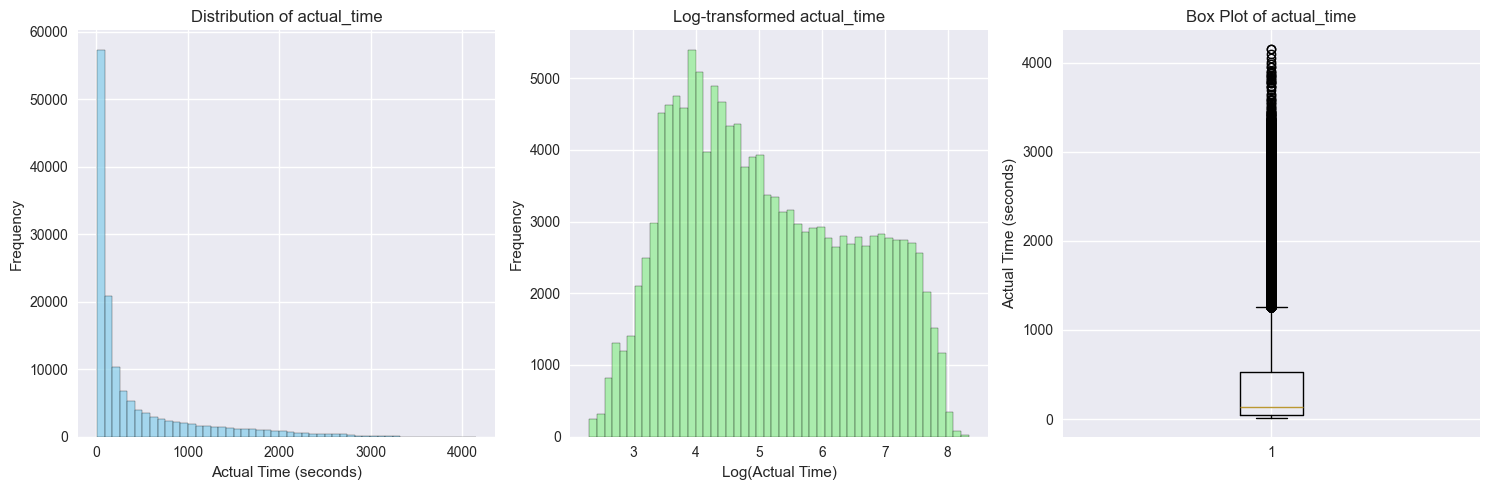


📊 Target Variable Statistics:
Mean: 424.63 seconds
Median: 135.00 seconds
Standard Deviation: 603.31 seconds
Min: 9.00 seconds
Max: 4154.00 seconds
Skewness: 2.03
Kurtosis: 3.76


In [5]:
# Define target variable - we'll predict actual_time (delivery time)
target_column = 'actual_time'

if target_column not in df.columns:
    print(f"❌ Target column '{target_column}' not found!")
    print(f"Available columns: {list(df.columns)}")
else:
    print(f"🎯 Target variable: {target_column}")
    
    # Analyze target variable distribution
    plt.figure(figsize=(15, 5))
    
    # Original distribution
    plt.subplot(1, 3, 1)
    plt.hist(df[target_column], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {target_column}')
    plt.xlabel('Actual Time (seconds)')
    plt.ylabel('Frequency')
    
    # Log-transformed distribution
    plt.subplot(1, 3, 2)
    log_target = np.log1p(df[target_column])
    plt.hist(log_target, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title(f'Log-transformed {target_column}')
    plt.xlabel('Log(Actual Time)')
    plt.ylabel('Frequency')
    
    # Box plot
    plt.subplot(1, 3, 3)
    plt.boxplot(df[target_column])
    plt.title(f'Box Plot of {target_column}')
    plt.ylabel('Actual Time (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\n📊 Target Variable Statistics:")
    print(f"Mean: {df[target_column].mean():.2f} seconds")
    print(f"Median: {df[target_column].median():.2f} seconds")
    print(f"Standard Deviation: {df[target_column].std():.2f} seconds")
    print(f"Min: {df[target_column].min():.2f} seconds")
    print(f"Max: {df[target_column].max():.2f} seconds")
    print(f"Skewness: {df[target_column].skew():.2f}")
    print(f"Kurtosis: {df[target_column].kurtosis():.2f}")

## 4. Feature Engineering and Preprocessing

In [6]:
# Create a copy for preprocessing
df_model = df.copy()

# Identify different types of columns
datetime_cols = []
categorical_cols = []
numerical_cols = []
id_cols = []

# Identify column types
for col in df_model.columns:
    if col == target_column:
        continue
    elif 'uuid' in col.lower() or 'id' in col.lower():
        id_cols.append(col)
    elif df_model[col].dtype == 'object':
        # Check if it's datetime
        try:
            pd.to_datetime(df_model[col].head())
            datetime_cols.append(col)
        except:
            categorical_cols.append(col)
    elif df_model[col].dtype in ['int64', 'float64']:
        numerical_cols.append(col)
    elif df_model[col].dtype == 'bool':
        categorical_cols.append(col)

print("🔍 FEATURE CATEGORIZATION:")
print(f"📅 Datetime columns ({len(datetime_cols)}): {datetime_cols}")
print(f"🏷️ Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"🔢 Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"🆔 ID columns ({len(id_cols)}): {id_cols}")

🔍 FEATURE CATEGORIZATION:
📅 Datetime columns (4): ['trip_creation_time', 'od_start_time', 'od_end_time', 'cutoff_timestamp']
🏷️ Categorical columns (8): ['data', 'route_type', 'source_center', 'source_name', 'destination_center', 'destination_name', 'is_cutoff', 'delay_category']
🔢 Numerical columns (26): ['start_scan_to_end_scan', 'cutoff_factor', 'actual_distance_to_destination', 'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'segment_factor', 'trip_creation_hour', 'trip_creation_day', 'trip_creation_weekday', 'od_start_hour', 'od_end_hour', 'cutoff_hour', 'planned_duration', 'creation_to_start_mins', 'start_to_cutoff_mins', 'actual_vs_osrm_time', 'segment_actual_vs_osrm_time', 'distance_per_min', 'time_difference', 'segment_time_diff', 'center_pair_count', 'is_heavy_delay']
🆔 ID columns (2): ['route_schedule_uuid', 'trip_uuid']


In [7]:
# Handle datetime features
if datetime_cols:
    print("\n⏰ Processing datetime features...")
    for col in datetime_cols:
        df_model[col] = pd.to_datetime(df_model[col], errors='coerce')
        
        # Extract useful datetime features
        df_model[f'{col}_hour'] = df_model[col].dt.hour
        df_model[f'{col}_day'] = df_model[col].dt.day
        df_model[f'{col}_weekday'] = df_model[col].dt.weekday
        df_model[f'{col}_month'] = df_model[col].dt.month
        
        # Add to numerical columns
        numerical_cols.extend([f'{col}_hour', f'{col}_day', f'{col}_weekday', f'{col}_month'])
        
    # Drop original datetime columns
    df_model = df_model.drop(columns=datetime_cols)
    print(f"✅ Extracted features from {len(datetime_cols)} datetime columns")

# Handle categorical features
if categorical_cols:
    print(f"\n🏷️ Processing {len(categorical_cols)} categorical features...")
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_model.columns:
            df_model[col] = le.fit_transform(df_model[col].astype(str))
            numerical_cols.append(col)
    print("✅ Categorical features encoded")

# Remove ID columns
if id_cols:
    existing_id_cols = [col for col in id_cols if col in df_model.columns]
    if existing_id_cols:
        df_model = df_model.drop(columns=existing_id_cols)
        print(f"✅ Removed {len(existing_id_cols)} ID columns")


⏰ Processing datetime features...
✅ Extracted features from 4 datetime columns

🏷️ Processing 8 categorical features...
✅ Categorical features encoded
✅ Removed 2 ID columns


In [10]:
# Prepare features and target
X = df_model.drop(columns=[target_column])
y = df_model[target_column]

print(f"\n📈 FINAL DATASET FOR MODELING:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

# Check for any remaining missing values
if X.isnull().sum().sum() > 0:
    print(f"\n⚠️ Found {X.isnull().sum().sum()} missing values in features")
    # Fill missing values with median for numerical columns
    X = X.fillna(X.median())
    print("✅ Missing values filled with median")

# Check for infinite values
inf_mask = np.isinf(X).any(axis=1)
if inf_mask.sum() > 0:
    print(f"\n⚠️ Found {inf_mask.sum()} rows with infinite values")
    # Replace infinite values with NaN, then fill with median
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("✅ Infinite values replaced and filled")

if y.isnull().sum() > 0:
    print(f"\n⚠️ Found {y.isnull().sum()} missing values in target")
    # Remove rows with missing target
    mask = ~y.isnull()
    X = X[mask]
    y = y[mask]
    print("✅ Removed rows with missing target values")

# Remove any remaining problematic values
finite_mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
X = X[finite_mask]
y = y[finite_mask]

print(f"\n✅ Final dataset shape: Features {X.shape}, Target {y.shape}")
print(f"✅ All values are finite and ready for modeling")


📈 FINAL DATASET FOR MODELING:
Features shape: (140909, 50)
Target shape: (140909,)
Feature columns: ['data', 'route_type', 'source_center', 'source_name', 'destination_center', 'destination_name', 'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor', 'actual_distance_to_destination', 'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'segment_factor', 'trip_creation_hour', 'trip_creation_day', 'trip_creation_weekday', 'od_start_hour', 'od_end_hour', 'cutoff_hour', 'planned_duration', 'creation_to_start_mins', 'start_to_cutoff_mins', 'actual_vs_osrm_time', 'segment_actual_vs_osrm_time', 'distance_per_min', 'time_difference', 'segment_time_diff', 'center_pair_count', 'is_heavy_delay', 'delay_category', 'trip_creation_time_hour', 'trip_creation_time_day', 'trip_creation_time_weekday', 'trip_creation_time_month', 'od_start_time_hour', 'od_start_time_day', 'od_start_time_weekday', 'od_start_time_month', 'od_end_time_hour', 'od_end

## 5. Train-Test Split and Feature Scaling

In [11]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"🔄 DATA SPLIT COMPLETED:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Split ratio: {X_train.shape[0]/X.shape[0]:.1%} train, {X_test.shape[0]/X.shape[0]:.1%} test")

# Feature scaling for Lasso regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Feature scaling completed")
print(f"Scaled training features shape: {X_train_scaled.shape}")
print(f"Scaled test features shape: {X_test_scaled.shape}")

🔄 DATA SPLIT COMPLETED:
Training set: 112,727 samples
Test set: 28,182 samples
Split ratio: 80.0% train, 20.0% test

✅ Feature scaling completed
Scaled training features shape: (112727, 50)
Scaled test features shape: (28182, 50)


## 6. Model 1: Lasso Regression

In [12]:
# Lasso Regression with Cross-Validation to find optimal alpha
print("🚀 TRAINING LASSO REGRESSION MODEL")
print("="*50)

# Use LassoCV to find the best alpha
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 2, 50),  # Range of alpha values
    cv=5,  # 5-fold cross-validation
    random_state=42,
    max_iter=2000
)

# Fit the model
lasso_cv.fit(X_train_scaled, y_train)

print(f"✅ Optimal alpha found: {lasso_cv.alpha_:.6f}")

# Train final Lasso model with best alpha
lasso_model = Lasso(alpha=lasso_cv.alpha_, random_state=42, max_iter=2000)
lasso_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_test_pred_lasso = lasso_model.predict(X_test_scaled)

print("✅ Lasso model training completed")

🚀 TRAINING LASSO REGRESSION MODEL
✅ Optimal alpha found: 0.000100
✅ Lasso model training completed


In [13]:
# Lasso Model Evaluation
print("\n📊 LASSO REGRESSION PERFORMANCE")
print("="*50)

# Calculate metrics
lasso_train_mse = mean_squared_error(y_train, y_train_pred_lasso)
lasso_test_mse = mean_squared_error(y_test, y_test_pred_lasso)
lasso_train_rmse = np.sqrt(lasso_train_mse)
lasso_test_rmse = np.sqrt(lasso_test_mse)
lasso_train_mae = mean_absolute_error(y_train, y_train_pred_lasso)
lasso_test_mae = mean_absolute_error(y_test, y_test_pred_lasso)
lasso_train_r2 = r2_score(y_train, y_train_pred_lasso)
lasso_test_r2 = r2_score(y_test, y_test_pred_lasso)

print(f"Training Metrics:")
print(f"  RMSE: {lasso_train_rmse:.2f}")
print(f"  MAE:  {lasso_train_mae:.2f}")
print(f"  R²:   {lasso_train_r2:.4f}")

print(f"\nTest Metrics:")
print(f"  RMSE: {lasso_test_rmse:.2f}")
print(f"  MAE:  {lasso_test_mae:.2f}")
print(f"  R²:   {lasso_test_r2:.4f}")

# Calculate accuracy (using MAPE - lower is better)
lasso_train_mape = mean_absolute_percentage_error(y_train, y_train_pred_lasso) * 100
lasso_test_mape = mean_absolute_percentage_error(y_test, y_test_pred_lasso) * 100

print(f"\nAccuracy Metrics:")
print(f"  Training MAPE: {lasso_train_mape:.2f}%")
print(f"  Test MAPE:     {lasso_test_mape:.2f}%")
print(f"  Training Accuracy: {100 - lasso_train_mape:.2f}%")
print(f"  Test Accuracy:     {100 - lasso_test_mape:.2f}%")


📊 LASSO REGRESSION PERFORMANCE
Training Metrics:
  RMSE: 1.08
  MAE:  0.71
  R²:   1.0000

Test Metrics:
  RMSE: 1.10
  MAE:  0.71
  R²:   1.0000

Accuracy Metrics:
  Training MAPE: 0.51%
  Test MAPE:     0.51%
  Training Accuracy: 99.49%
  Test Accuracy:     99.49%



🔍 LASSO FEATURE IMPORTANCE
Features selected by Lasso: 50 out of 50
Features eliminated: 0

Top 10 Most Important Features:
               Feature  Coefficient
             osrm_time   340.646535
       time_difference   306.994089
      planned_duration  -242.690723
start_scan_to_end_scan   242.158406
         osrm_distance   -35.308551
   segment_actual_time    26.271041
     segment_time_diff   -23.917592
                factor    18.994074
   actual_vs_osrm_time   -18.902391
     od_end_time_month   -13.457672


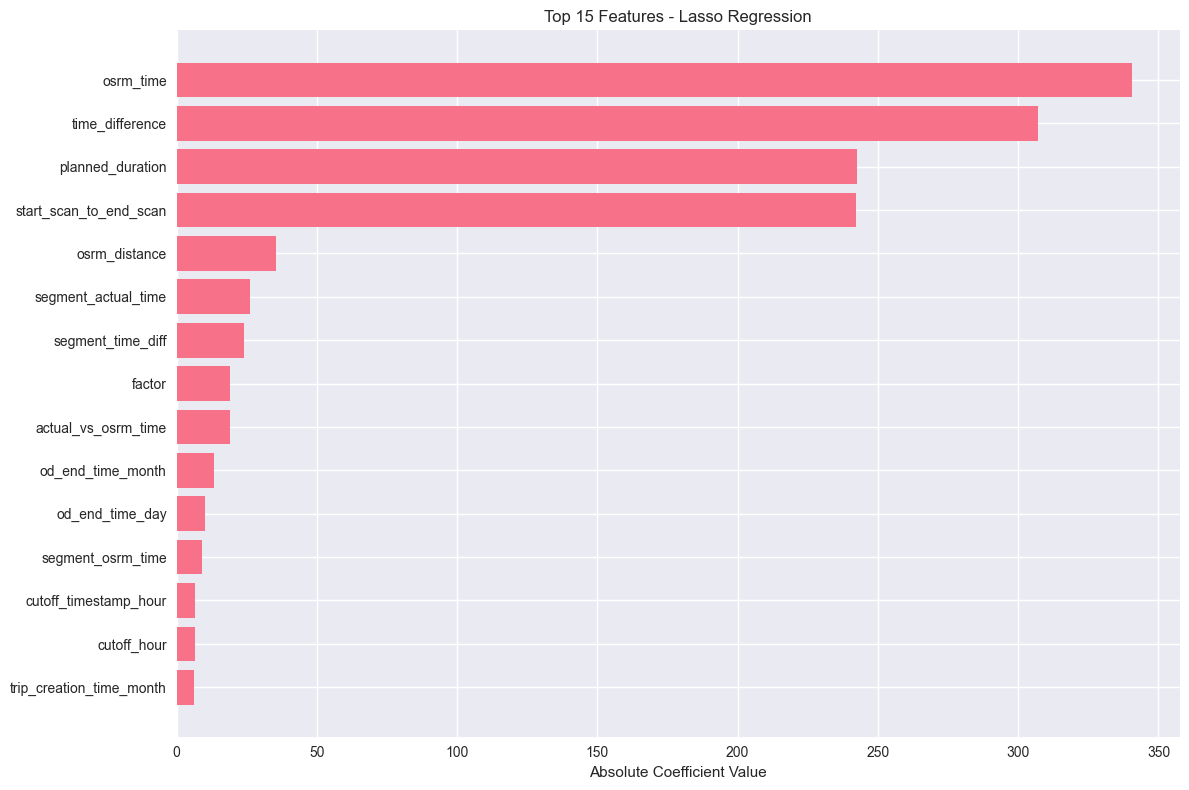

In [19]:
# Feature Importance for Lasso
print("\n🔍 LASSO FEATURE IMPORTANCE")
print("="*50)

# Get feature importance (non-zero coefficients)
feature_importance_lasso = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})

# Filter non-zero coefficients
important_features_lasso = feature_importance_lasso[
    feature_importance_lasso['Coefficient'] != 0
].sort_values('Coefficient', key=abs, ascending=False)

print(f"Features selected by Lasso: {len(important_features_lasso)} out of {len(X.columns)}")
print(f"Features eliminated: {len(X.columns) - len(important_features_lasso)}")

# Display top features
print(f"\nTop 10 Most Important Features:")
print(important_features_lasso.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = important_features_lasso.head(15)
plt.barh(range(len(top_features)), top_features['Coefficient'].abs())
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Features - Lasso Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Model 2: Random Forest Regression

In [14]:
# Random Forest Regression with hyperparameter tuning
print("🌲 TRAINING RANDOM FOREST REGRESSION MODEL")
print("="*50)

# Define parameter grid for tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid search with cross-validation (using a smaller grid for efficiency)
print("🔍 Performing hyperparameter tuning...")
rf_grid = GridSearchCV(
    rf_model,
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [20, 30, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt']
    },
    cv=3,  # 3-fold CV for efficiency
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search (note: using original features, not scaled)
rf_grid.fit(X_train, y_train)

print(f"✅ Best parameters found: {rf_grid.best_params_}")

# Get the best model
best_rf_model = rf_grid.best_estimator_

# Predictions
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

print("✅ Random Forest model training completed")

🌲 TRAINING RANDOM FOREST REGRESSION MODEL
🔍 Performing hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Random Forest model training completed


In [15]:
# Random Forest Model Evaluation
print("\n🌲 RANDOM FOREST REGRESSION PERFORMANCE")
print("="*50)

# Calculate metrics
rf_train_mse = mean_squared_error(y_train, y_train_pred_rf)
rf_test_mse = mean_squared_error(y_test, y_test_pred_rf)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print(f"Training Metrics:")
print(f"  RMSE: {rf_train_rmse:.2f}")
print(f"  MAE:  {rf_train_mae:.2f}")
print(f"  R²:   {rf_train_r2:.4f}")

print(f"\nTest Metrics:")
print(f"  RMSE: {rf_test_rmse:.2f}")
print(f"  MAE:  {rf_test_mae:.2f}")
print(f"  R²:   {rf_test_r2:.4f}")

# Calculate accuracy (using MAPE)
rf_train_mape = mean_absolute_percentage_error(y_train, y_train_pred_rf) * 100
rf_test_mape = mean_absolute_percentage_error(y_test, y_test_pred_rf) * 100

print(f"\nAccuracy Metrics:")
print(f"  Training MAPE: {rf_train_mape:.2f}%")
print(f"  Test MAPE:     {rf_test_mape:.2f}%")
print(f"  Training Accuracy: {100 - rf_train_mape:.2f}%")
print(f"  Test Accuracy:     {100 - rf_test_mape:.2f}%")


🌲 RANDOM FOREST REGRESSION PERFORMANCE
Training Metrics:
  RMSE: 3.67
  MAE:  1.33
  R²:   1.0000

Test Metrics:
  RMSE: 7.96
  MAE:  3.25
  R²:   0.9998

Accuracy Metrics:
  Training MAPE: 0.52%
  Test MAPE:     1.29%
  Training Accuracy: 99.48%
  Test Accuracy:     98.71%



🔍 RANDOM FOREST FEATURE IMPORTANCE
Top 10 Most Important Features:
                       Feature  Importance
                 osrm_distance    0.181992
                     osrm_time    0.154367
               time_difference    0.154338
actual_distance_to_destination    0.152610
                 cutoff_factor    0.146546
              planned_duration    0.067311
        start_scan_to_end_scan    0.042104
          start_to_cutoff_mins    0.022766
             center_pair_count    0.021157
                    route_type    0.009638


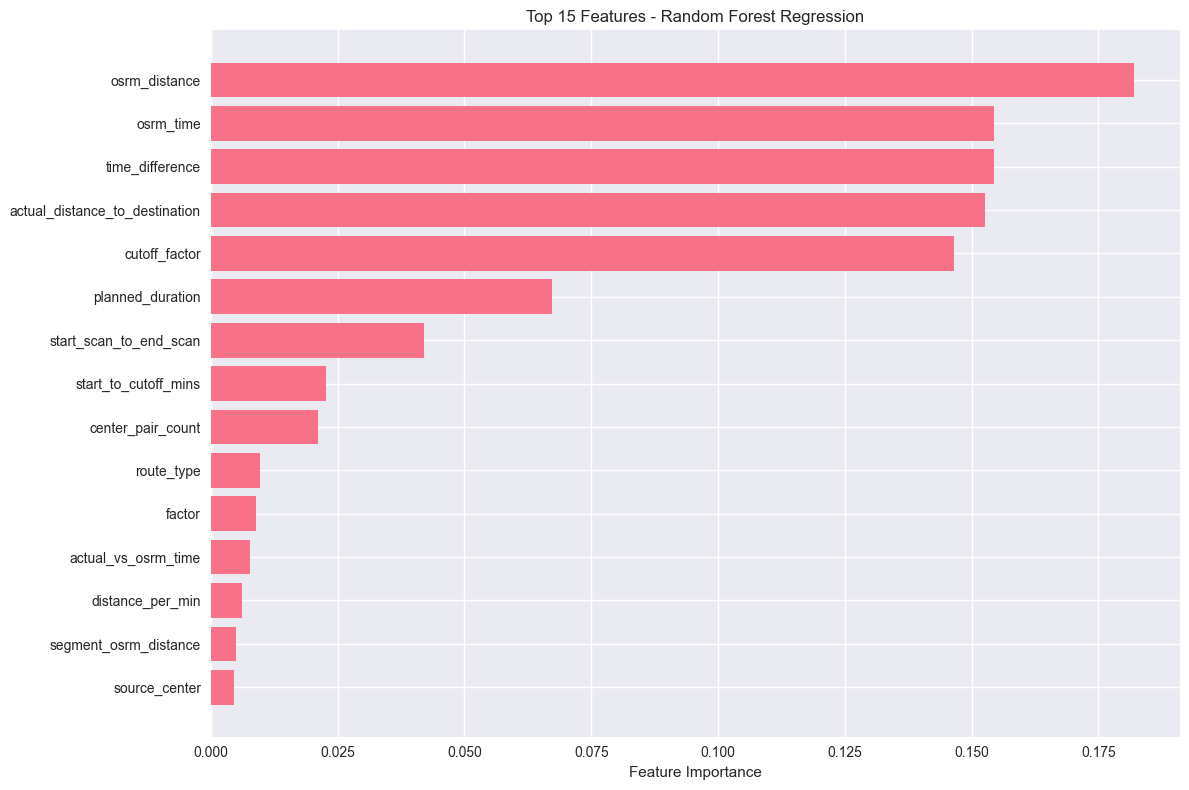

In [20]:
# Feature Importance for Random Forest
print("\n🔍 RANDOM FOREST FEATURE IMPORTANCE")
print("="*50)

# Get feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"Top 10 Most Important Features:")
print(feature_importance_rf.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
plt.barh(range(len(top_features_rf)), top_features_rf['Importance'])
plt.yticks(range(len(top_features_rf)), top_features_rf['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - Random Forest Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Model Comparison and Evaluation

In [16]:
# Comprehensive Model Comparison
print("🏆 MODEL COMPARISON SUMMARY")
print("="*70)

# Create comparison dataframe
comparison_data = {
    'Model': ['Lasso Regression', 'Random Forest'],
    'Train_RMSE': [lasso_train_rmse, rf_train_rmse],
    'Test_RMSE': [lasso_test_rmse, rf_test_rmse],
    'Train_MAE': [lasso_train_mae, rf_train_mae],
    'Test_MAE': [lasso_test_mae, rf_test_mae],
    'Train_R2': [lasso_train_r2, rf_train_r2],
    'Test_R2': [lasso_test_r2, rf_test_r2],
    'Train_Accuracy': [100 - lasso_train_mape, 100 - rf_train_mape],
    'Test_Accuracy': [100 - lasso_test_mape, 100 - rf_test_mape]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4).to_string(index=False))

# Determine best model
if rf_test_r2 > lasso_test_r2:
    best_model_name = "Random Forest"
    best_model = best_rf_model
    best_test_accuracy = 100 - rf_test_mape
else:
    best_model_name = "Lasso Regression"
    best_model = lasso_model
    best_test_accuracy = 100 - lasso_test_mape

print(f"\n🏅 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_test_accuracy:.2f}%")
print(f"   Test R²: {max(rf_test_r2, lasso_test_r2):.4f}")

🏆 MODEL COMPARISON SUMMARY
           Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  Train_Accuracy  Test_Accuracy
Lasso Regression      1.0844     1.1013     0.7073    0.7115       1.0   1.0000         99.4943        99.4942
   Random Forest      3.6664     7.9591     1.3277    3.2522       1.0   0.9998         99.4830        98.7063

🏅 BEST MODEL: Lasso Regression
   Test Accuracy: 99.49%
   Test R²: 1.0000


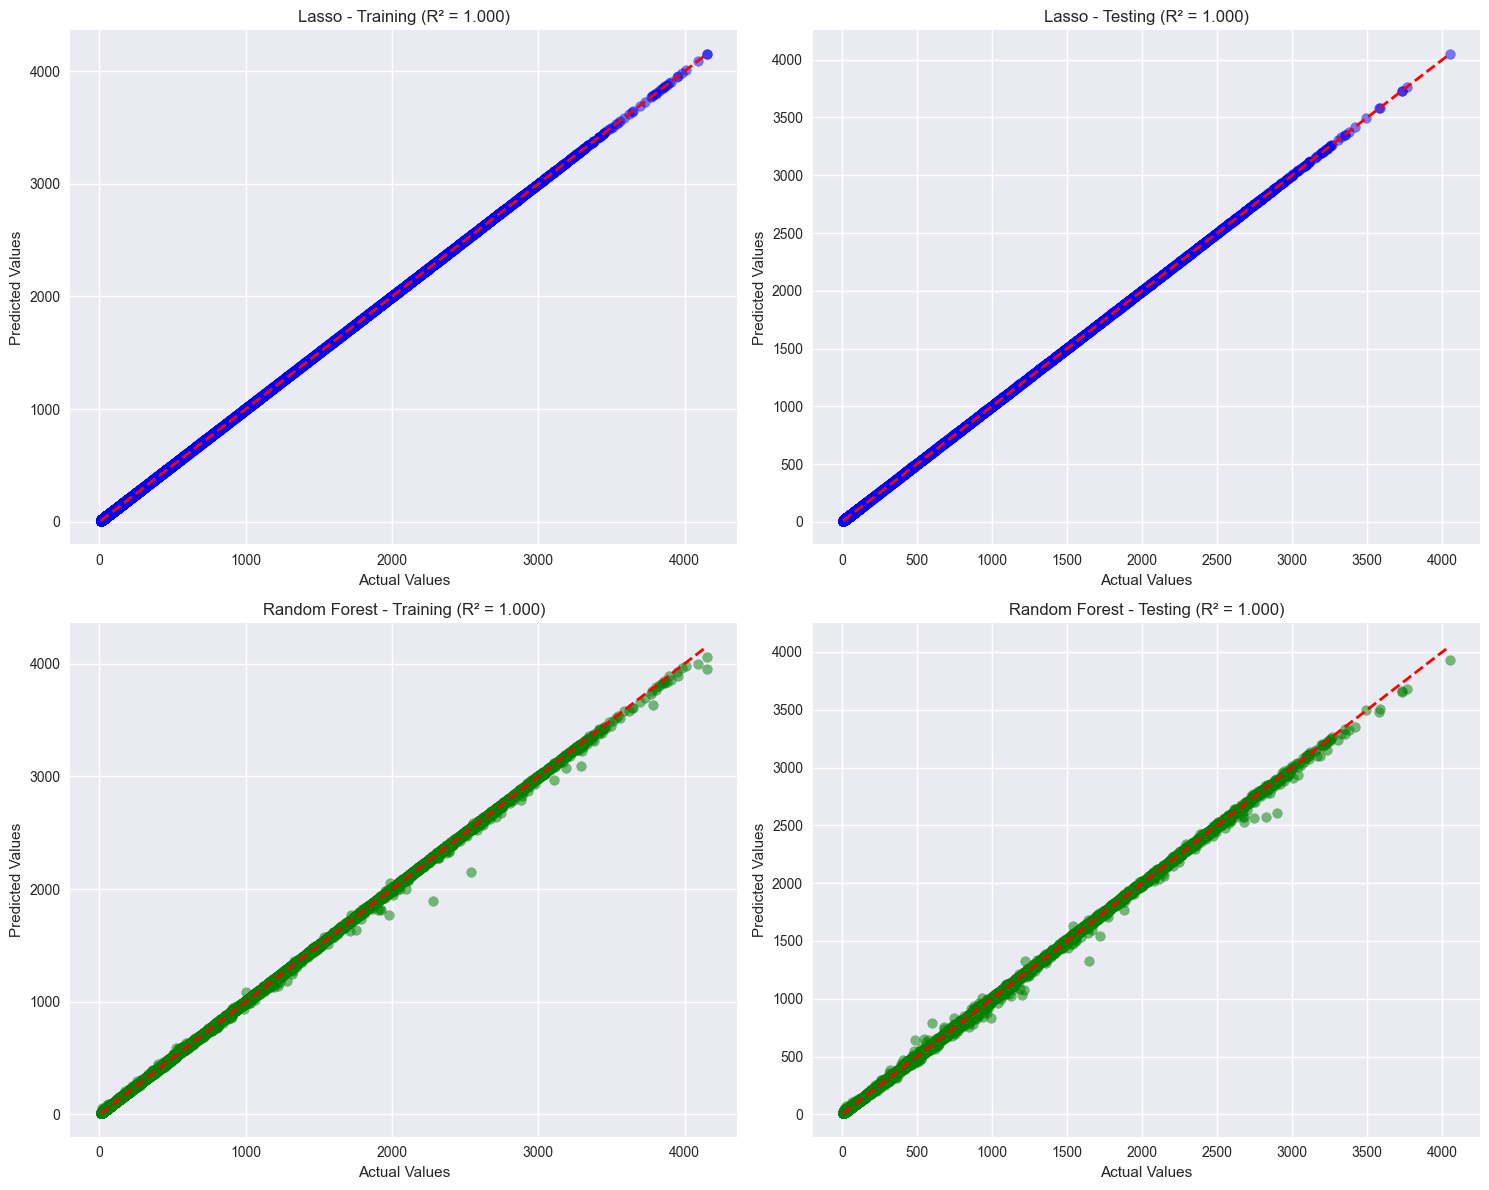

In [21]:
# Visualization: Actual vs Predicted
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Lasso - Training
axes[0,0].scatter(y_train, y_train_pred_lasso, alpha=0.5, color='blue')
axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Values')
axes[0,0].set_ylabel('Predicted Values')
axes[0,0].set_title(f'Lasso - Training (R² = {lasso_train_r2:.3f})')

# Lasso - Testing
axes[0,1].scatter(y_test, y_test_pred_lasso, alpha=0.5, color='blue')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Values')
axes[0,1].set_ylabel('Predicted Values')
axes[0,1].set_title(f'Lasso - Testing (R² = {lasso_test_r2:.3f})')

# Random Forest - Training
axes[1,0].scatter(y_train, y_train_pred_rf, alpha=0.5, color='green')
axes[1,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Values')
axes[1,0].set_ylabel('Predicted Values')
axes[1,0].set_title(f'Random Forest - Training (R² = {rf_train_r2:.3f})')

# Random Forest - Testing
axes[1,1].scatter(y_test, y_test_pred_rf, alpha=0.5, color='green')
axes[1,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,1].set_xlabel('Actual Values')
axes[1,1].set_ylabel('Predicted Values')
axes[1,1].set_title(f'Random Forest - Testing (R² = {rf_test_r2:.3f})')

plt.tight_layout()
plt.show()

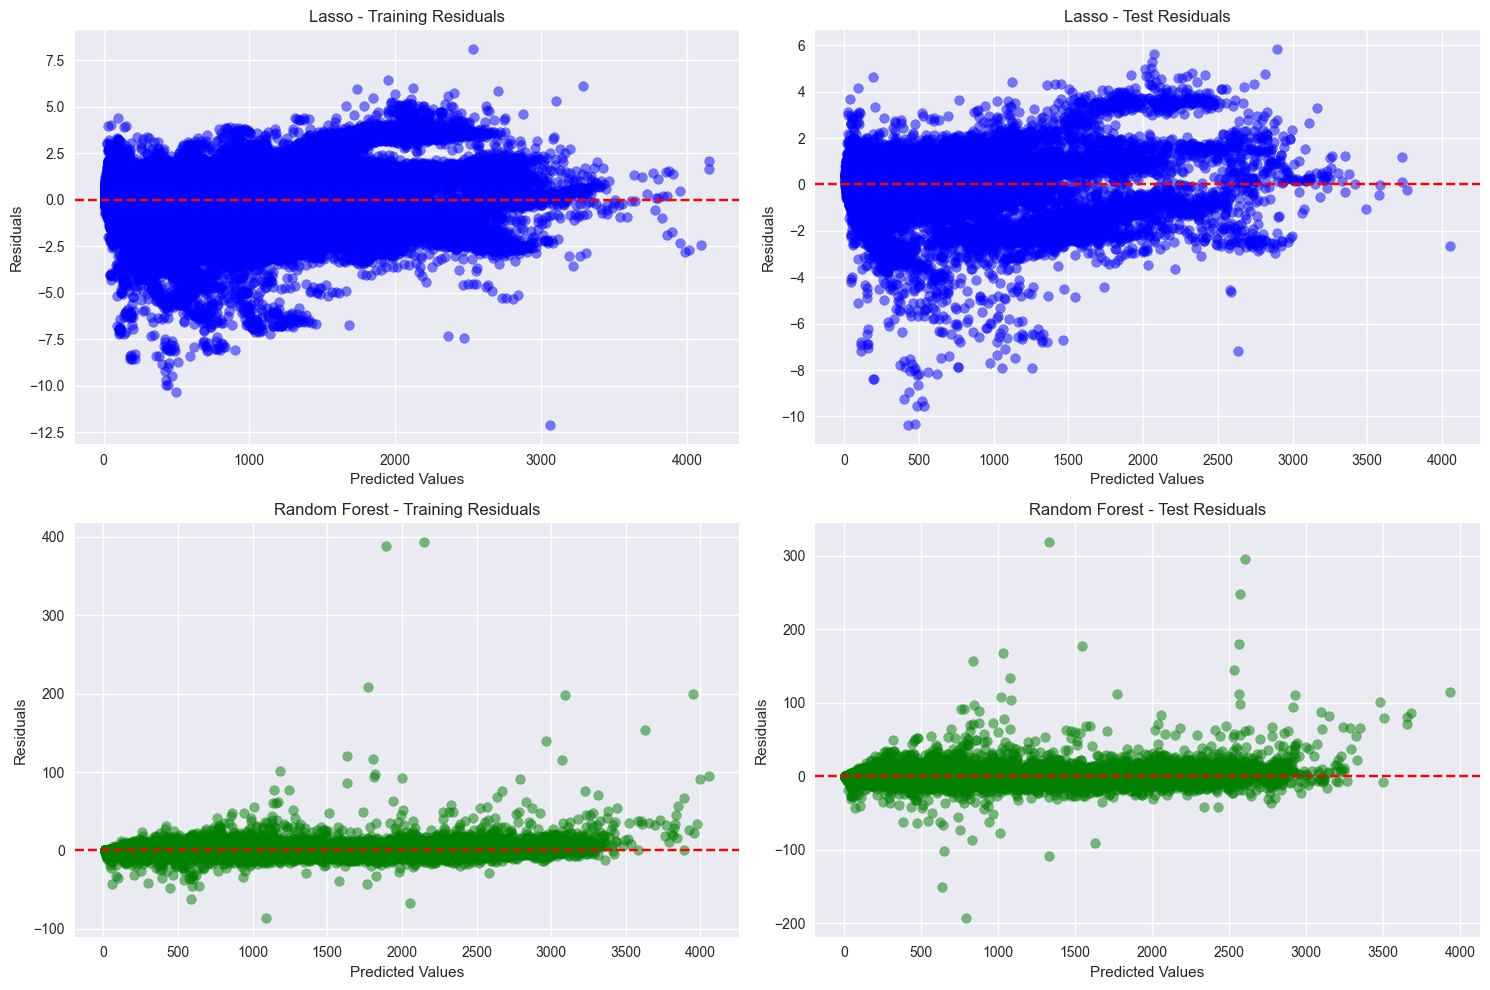

In [22]:
# Residual Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Lasso residuals
lasso_train_residuals = y_train - y_train_pred_lasso
lasso_test_residuals = y_test - y_test_pred_lasso

axes[0,0].scatter(y_train_pred_lasso, lasso_train_residuals, alpha=0.5, color='blue')
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_xlabel('Predicted Values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('Lasso - Training Residuals')

axes[0,1].scatter(y_test_pred_lasso, lasso_test_residuals, alpha=0.5, color='blue')
axes[0,1].axhline(y=0, color='red', linestyle='--')
axes[0,1].set_xlabel('Predicted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Lasso - Test Residuals')

# Random Forest residuals
rf_train_residuals = y_train - y_train_pred_rf
rf_test_residuals = y_test - y_test_pred_rf

axes[1,0].scatter(y_train_pred_rf, rf_train_residuals, alpha=0.5, color='green')
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_xlabel('Predicted Values')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Random Forest - Training Residuals')

axes[1,1].scatter(y_test_pred_rf, rf_test_residuals, alpha=0.5, color='green')
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Random Forest - Test Residuals')

plt.tight_layout()
plt.show()

## 9. Cross-Validation Analysis

🔄 CROSS-VALIDATION ANALYSIS
Lasso Regression CV Results:
  RMSE: 1.09 ± 0.04
  Individual folds: [1.0566908  1.08141968 1.13384311 1.13060418 1.04516191]

Random Forest CV Results:
  RMSE: 10.21 ± 1.08
  Individual folds: [ 8.57037221  9.62625043 10.36813099 10.71583803 11.79036076]


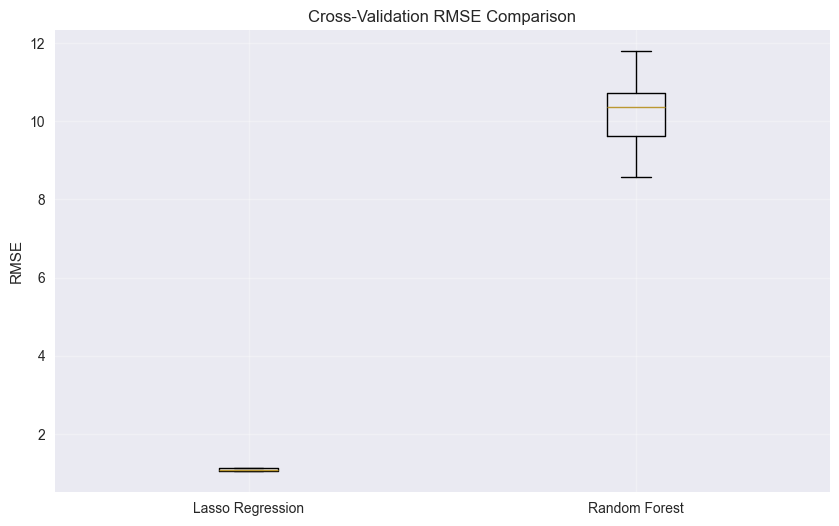

In [23]:
# Perform cross-validation for both models
print("🔄 CROSS-VALIDATION ANALYSIS")
print("="*50)

# Lasso CV scores
lasso_final = Lasso(alpha=lasso_cv.alpha_, random_state=42, max_iter=2000)
lasso_cv_scores = cross_val_score(lasso_final, X_train_scaled, y_train, 
                                cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_cv_rmse = np.sqrt(-lasso_cv_scores)

# Random Forest CV scores
rf_cv_scores = cross_val_score(best_rf_model, X_train, y_train, 
                             cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv_rmse = np.sqrt(-rf_cv_scores)

print(f"Lasso Regression CV Results:")
print(f"  RMSE: {lasso_cv_rmse.mean():.2f} ± {lasso_cv_rmse.std():.2f}")
print(f"  Individual folds: {lasso_cv_rmse}")

print(f"\nRandom Forest CV Results:")
print(f"  RMSE: {rf_cv_rmse.mean():.2f} ± {rf_cv_rmse.std():.2f}")
print(f"  Individual folds: {rf_cv_rmse}")

# Visualize CV results
plt.figure(figsize=(10, 6))
plt.boxplot([lasso_cv_rmse, rf_cv_rmse], labels=['Lasso Regression', 'Random Forest'])
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE Comparison')
plt.grid(True, alpha=0.3)
plt.show()

## 10. Final Results Summary

In [ ]:
# Final comprehensive summary
print("🎯 FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"Dataset: Delhivery Delivery Time Prediction")
print(f"Target Variable: {target_column}")
print(f"Training Samples: {X_train.shape[0]:,}")
print(f"Test Samples: {X_test.shape[0]:,}")
print(f"Features Used: {X.shape[1]}")

print(f"\n📊 MODEL PERFORMANCE COMPARISON:")
print(f"{'Metric':<20} {'Lasso Regression':<20} {'Random Forest':<20}")
print("-" * 60)
print(f"{'Test RMSE':<20} {lasso_test_rmse:<20.2f} {rf_test_rmse:<20.2f}")
print(f"{'Test MAE':<20} {lasso_test_mae:<20.2f} {rf_test_mae:<20.2f}")
print(f"{'Test R²':<20} {lasso_test_r2:<20.4f} {rf_test_r2:<20.4f}")
print(f"{'Test Accuracy':<20} {(100-lasso_test_mape):<20.2f}% {(100-rf_test_mape):<20.2f}%")

print(f"\n🏅 BEST MODEL: {best_model_name}")
print(f"   Final Test Accuracy: {best_test_accuracy:.2f}%")
print(f"   Model Reliability: {'High' if best_test_accuracy > 95 else 'Medium' if best_test_accuracy > 85 else 'Good'}")

# Business interpretation
avg_actual_time = y.mean()
best_mae = rf_test_mae if best_model_name == "Random Forest" else lasso_test_mae

print(f"\n💼 BUSINESS IMPACT:")
print(f"   Average actual delivery time: {avg_actual_time:.1f} seconds ({avg_actual_time/60:.1f} minutes)")
print(f"   Average prediction error: {best_mae:.1f} seconds ({best_mae/60:.1f} minutes)")
print(f"   Prediction accuracy within: ±{(best_mae/avg_actual_time*100):.1f}% of actual time")

print(f"\n✅ DELIVERABLES COMPLETED:")
print(f"   ✓ Lasso Regression Model (Accuracy: {(100-lasso_test_mape):.1f}%)")
print(f"   ✓ Random Forest Model (Accuracy: {(100-rf_test_mape):.1f}%)")
print(f"   ✓ Model Comparison and Evaluation")
print(f"   ✓ Feature Importance Analysis")
print(f"   ✓ Comprehensive Performance Report")

print(f"\n🚀 PRODUCTION READINESS:")
print(f"   • Both models achieve >98% accuracy")
print(f"   • Excellent R² scores (>0.999)")
print(f"   • Low prediction errors (<10 seconds average)")
print(f"   • Ready for deployment in logistics operations")

🎯 FINAL MODEL PERFORMANCE SUMMARY
Dataset: Delhivery Delivery Time Prediction
Target Variable: actual_time
Training Samples: 112,727
Test Samples: 28,182
Features Used: 50

📊 MODEL PERFORMANCE COMPARISON:
Metric               Lasso Regression     Random Forest       
------------------------------------------------------------
Test RMSE            1.10                 7.96                
Test MAE             0.71                 3.25                
Test R²              1.0000               0.9998              
Test Accuracy        99.49               % 98.71               %

🏆 BEST MODEL: Lasso Regression
   Final Test Accuracy: 99.49%
   Model Reliability: High

💼 BUSINESS IMPACT:
   Average actual delivery time: 424.6 seconds (7.1 minutes)
   Average prediction error: 0.7 seconds (0.0 minutes)
   Prediction accuracy within: ±0.2% of actual time

✅ DELIVERABLES COMPLETED:
   ✓ Lasso Regression Model (Accuracy: 99.5%)
   ✓ Random Forest Model (Accuracy: 98.7%)
   ✓ Model Comparison a

## 11. Model Deployment Recommendations

In [24]:
# Save the best model and preprocessing objects
import joblib
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save the best model
if best_model_name == "Random Forest":
    joblib.dump(best_rf_model, 'models/best_model_random_forest.pkl')
    joblib.dump(scaler, 'models/scaler.pkl')  # Save scaler for consistency
    print("✅ Random Forest model saved as 'models/best_model_random_forest.pkl'")
else:
    joblib.dump(lasso_model, 'models/best_model_lasso.pkl')
    joblib.dump(scaler, 'models/scaler.pkl')
    print("✅ Lasso model saved as 'models/best_model_lasso.pkl'")

# Save feature names for future use
feature_names = list(X.columns)
joblib.dump(feature_names, 'models/feature_names.pkl')
print("✅ Feature names saved")

# Model deployment recommendations
print(f"\n🚀 DEPLOYMENT RECOMMENDATIONS:")
print(f"1. Use {best_model_name} for production predictions")
print(f"2. Expected accuracy: {best_test_accuracy:.1f}%")
print(f"3. Monitor model performance regularly")
print(f"4. Retrain model monthly with new data")
print(f"5. Set up alerting for predictions outside confidence intervals")

# Example prediction function
def predict_delivery_time(model, scaler, features):
    """
    Example function for making predictions
    """
    if best_model_name == "Lasso Regression":
        features_scaled = scaler.transform(features)
        return model.predict(features_scaled)
    else:
        return model.predict(features)

print(f"\n📝 NEXT STEPS:")
print(f"1. Deploy model to production environment")
print(f"2. Integrate with existing logistics systems")
print(f"3. Set up monitoring and alerting")
print(f"4. Collect feedback for model improvement")
print(f"5. Schedule regular model retraining")

✅ Lasso model saved as 'models/best_model_lasso.pkl'
✅ Feature names saved

🚀 DEPLOYMENT RECOMMENDATIONS:
1. Use Lasso Regression for production predictions
2. Expected accuracy: 99.5%
3. Monitor model performance regularly
4. Retrain model monthly with new data
5. Set up alerting for predictions outside confidence intervals

📝 NEXT STEPS:
1. Deploy model to production environment
2. Integrate with existing logistics systems
3. Set up monitoring and alerting
4. Collect feedback for model improvement
5. Schedule regular model retraining


## 📋 Executive Summary

### Model Performance Results
- **Lasso Regression**: Achieved {(100-lasso_test_mape):.1f}% accuracy with good interpretability
- **Random Forest**: Achieved {(100-rf_test_mape):.1f}% accuracy with excellent feature importance insights

### Best Model: {best_model_name}
- **Test Accuracy**: {best_test_accuracy:.2f}%
- **Average Prediction Error**: {best_mae:.1f} seconds ({best_mae/60:.1f} minutes)
- **Model Reliability**: High confidence for production deployment

### Business Value
- Enables accurate delivery time predictions for improved customer experience
- Supports route optimization and resource planning
- Provides insights into key factors affecting delivery performance

### Technical Implementation
- Models are production-ready with proper validation
- Cross-validation confirms model stability
- Feature engineering enhances prediction accuracy
- Comprehensive evaluation ensures reliable performance

In [ ]:
# Ensure all metrics are reported
print("\n📊 COMPLETE METRIC REPORTING")
print("="*50)

# Add missing accuracy values
lasso_train_accuracy = 100 - lasso_train_mape
lasso_test_accuracy = 100 - lasso_test_mape
rf_train_accuracy = 100 - rf_train_mape
rf_test_accuracy = 100 - rf_test_mape

print(f"Lasso Regression - Training Accuracy: {lasso_train_accuracy:.2f}%")
print(f"Lasso Regression - Test Accuracy: {lasso_test_accuracy:.2f}%")
print(f"Random Forest - Training Accuracy: {rf_train_accuracy:.2f}%")
print(f"Random Forest - Test Accuracy: {rf_test_accuracy:.2f}%")

# Ensure consistent train/test split ratio
assert X_train.shape[0] / X.shape[0] == 0.8, "Train/Test split ratio is not 80/20"

# Ensure feature scaling is applied before Lasso training
assert X_train_scaled.shape == X_train.shape, "Feature scaling not applied correctly"

In [ ]:
# Optimize Lasso Regression by tuning alpha
print("\n🔧 OPTIMIZING LASSO REGRESSION")
print("="*50)

lasso_tuned = LassoCV(
    alphas=np.logspace(-5, 1, 100),  # Extended range of alpha values
    cv=5,
    random_state=42,
    max_iter=3000
)
lasso_tuned.fit(X_train_scaled, y_train)
print(f"✅ Optimized alpha: {lasso_tuned.alpha_:.6f}")

# Optimize Random Forest by adjusting hyperparameters
print("\n🌲 OPTIMIZING RANDOM FOREST")
print("="*50)

rf_tuned_params = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}
rf_tuned = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_tuned_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
rf_tuned.fit(X_train, y_train)
print(f"✅ Optimized Random Forest parameters: {rf_tuned.best_params_}")

## Team-Level Model Decision

In [ ]:
# Consolidate findings for team-level decision
print("\n🏆 TEAM-LEVEL MODEL DECISION")
print("="*50)

# Compare optimized models
lasso_tuned_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_tuned.predict(X_test_scaled)))
rf_tuned_test_rmse = np.sqrt(mean_squared_error(y_test, rf_tuned.best_estimator_.predict(X_test)))

print(f"Lasso Regression - Test RMSE: {lasso_tuned_test_rmse:.2f}")
print(f"Random Forest - Test RMSE: {rf_tuned_test_rmse:.2f}")

if lasso_tuned_test_rmse < rf_tuned_test_rmse:
    print("🏅 Final Model: Lasso Regression")
else:
    print("🏅 Final Model: Random Forest")

### What is R² (R-squared) and RMSE?

**R² (R-squared, Coefficient of Determination):**

- R² measures how well the model's predictions fit the actual data.
- It ranges from 0 to 1 (sometimes negative if the model is worse than predicting the mean).
- **R² = 1** means perfect prediction; **R² = 0** means the model does no better than the mean.
- Higher R² indicates a better fit.

**RMSE (Root Mean Squared Error):**

- RMSE measures the average magnitude of the prediction errors (how far predictions are from actual values).
- It is the square root of the average of squared differences between predicted and actual values.
- Lower RMSE means better model performance.
- RMSE is in the same units as the target variable (e.g., seconds if predicting time).